In [1]:
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider

### 1. Visualise the different common statistical distributions

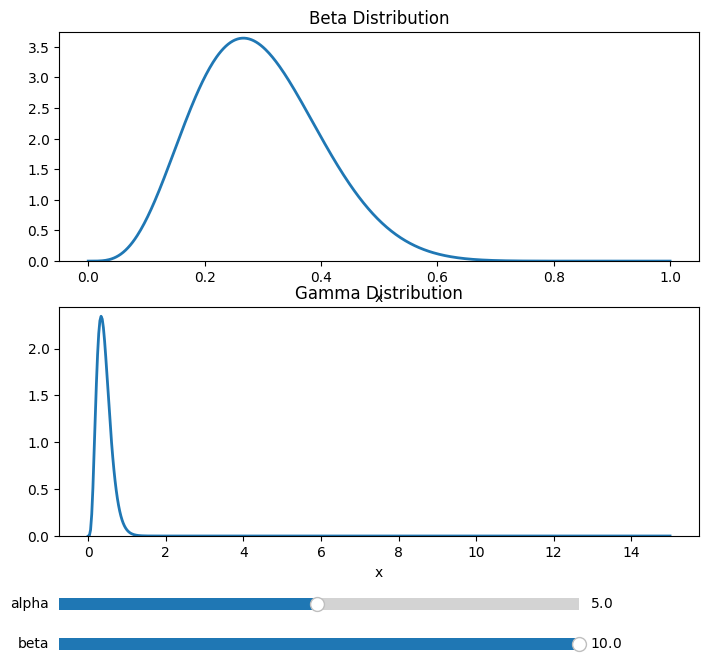

In [2]:
# Most distributions, I know how they look like, but here is a visualisation of Beta and Gamma (since they share the same set of parameters)
alpha = 5
beta = 12

# Set up the figure and axis
fig, axes = plt.subplots(2, 1, figsize=(8, 8))
fig.subplots_adjust(left=0.1, right=0.9, bottom=0.25)

# Create an array of x values
x = np.linspace(0, 1, 500)
x_gamma = np.linspace(0, 15, 500)

# Plot the initial beta and gamma distributions
y_beta = stats.beta.pdf(x, alpha, beta)
y_gamma = stats.gamma.pdf(x_gamma, alpha, scale=1/beta)
line_beta, = axes[0].plot(x, y_beta, lw=2)
line_gamma, = axes[1].plot(x_gamma, y_gamma, lw=2)

axes[0].set_ylim(0, max(y_beta) + 0.1)
axes[1].set_ylim(0, max(y_gamma) + 0.1)

# Add titles
axes[0].set_title('Beta Distribution')
axes[1].set_title('Gamma Distribution')
axes[0].set_xlabel('x')
axes[1].set_xlabel('x')

# Create sliders
axcolor = 'lightgoldenrodyellow'
ax_alpha = plt.axes([0.1, 0.15, 0.65, 0.03], facecolor=axcolor)
ax_beta = plt.axes([0.1, 0.1, 0.65, 0.03], facecolor=axcolor)

s_alpha = Slider(ax_alpha, 'alpha', 0.1, 10.0, valinit=alpha)
s_beta = Slider(ax_beta, 'beta', 0.1, 10.0, valinit=beta)

# The function to be called anytime a slider's value changes
def update(val):
    line_beta.set_ydata(stats.beta.pdf(x, s_alpha.val, s_beta.val))
    line_gamma.set_ydata(stats.gamma.pdf(x_gamma, s_alpha.val, scale=1/s_beta.val))
    axes[0].set_ylim(0, max(stats.beta.pdf(x, s_alpha.val, s_beta.val)) + 0.1)
    axes[1].set_ylim(0, max(stats.gamma.pdf(x_gamma, s_alpha.val, scale=1/s_beta.val)) + 0.1)
    fig.canvas.draw_idle()

# Register the update function with each slider
s_alpha.on_changed(update)
s_beta.on_changed(update)

# Show the plot
plt.show()

### 2. Sampling from different distributions (Monte Carlo)

#### 2.1 Gamma distribution sampling

See that scipy.stats has a gamma.rvs to randomly sample. Note that for distributions with tractable inversible CDFs, we can always create a Uniform[0,1] and feed that into an inverse CDF but this is not very applicable.

Python already has built in things to randomly sample from a distribution.

In [3]:
#Set the sample size. Say we sample from a gamma distribution
a = 2.0
b = 1.0/3.0
m = 10000

 0.50 of the samples are less than 5


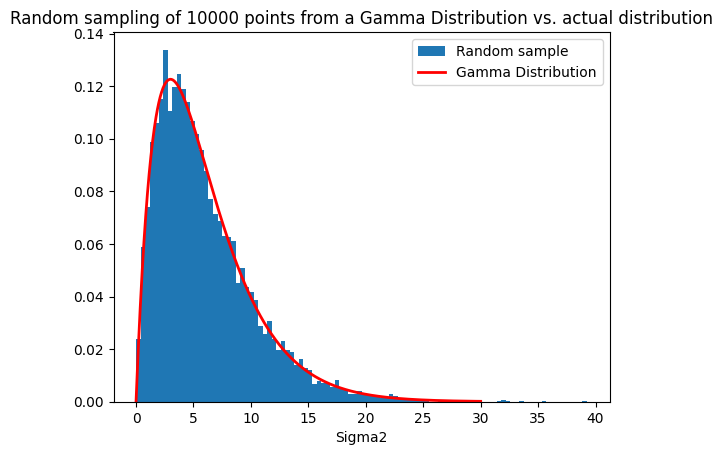

In [4]:
theta = stats.gamma.rvs(a, scale=1/b, size=m)
print(f"{np.mean(theta<5): .2f} of the samples are less than 5")
#Plot a histogram and a gamma distribution of the same parameters
x = np.linspace(0, 30, 1000)
y = stats.gamma.pdf(x, a, scale=1/b)

plt.hist(theta, bins=100, density=True, label='Random sample')
plt.plot(x, y, 'r-', lw=2, label='Gamma Distribution')
plt.title(f"Random sampling of {m} points from a Gamma Distribution vs. actual distribution")
plt.xlabel('Sigma2')
plt.legend()
plt.show()
#The sampling does well!

In [5]:
#Get the quantile of theta
q = 0.95
print(f"The {q*100:.0f}th percentile of theta is {stats.gamma.ppf(q, a, scale=1/b): .2f}")
#How about the 95% percentile of the theta vector that I sampled?
print(f"The {q*100:.0f}th percentile of the sample is {np.percentile(theta, q*100): .2f}")


The 95th percentile of theta is  14.23
The 95th percentile of the sample is  14.23


#### 2.1.1 Gamma Mean and Variance Deviance

In [6]:
#Our monte carlo mean and the actual mean is:
theta_mean = np.mean(theta); gamma_mean = a/b
#Our monte carlo variance is:
theta_var = np.var(theta); gamma_var = a/(b**2)

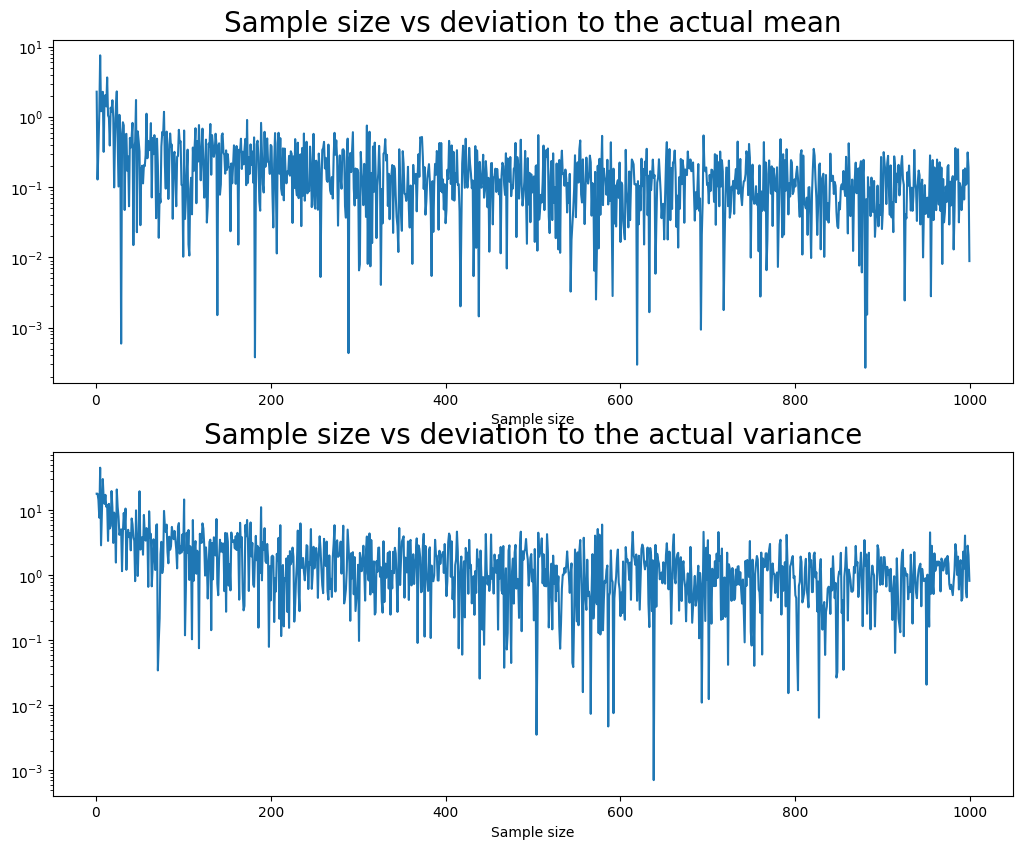

In [7]:
#Now plot the relationship between the number of samples and the deviation to the acutal mean:
a = 2.0
b = 1.0/3.0
res_deviation = np.array([])
for m in range(1,1000):
    theta = stats.gamma.rvs(a, scale=1/b, size=m)
    theta_mean = np.mean(theta)
    theta_var = np.var(theta)
    #Append m and theta_mean to make a (m, 3) array
    res_deviation = np.append(res_deviation, [m, abs(theta_mean - gamma_mean), abs(theta_var - gamma_var)])

res_deviation = res_deviation.reshape(-1,3)

#Make a (2,1) subplot with axes[0] showing mean and axes[1] shwoing variance
fig, axes = plt.subplots(2, 1, figsize=(12, 12))
fig.subplots_adjust(left=0.1, right=0.9, bottom=0.25)

#Set both ys as log scales
axes[0].set_yscale('log')
axes[1].set_yscale('log')

axes[0].plot(res_deviation[:,0], res_deviation[:,1])
axes[0].set_title("Sample size vs deviation to the actual mean", size=20)
axes[0].set_xlabel("Sample size")
axes[1].plot(res_deviation[:,0], res_deviation[:,2])
axes[1].set_title("Sample size vs deviation to the actual variance", size=20)
axes[1].set_xlabel("Sample size")
plt.show()

See that many of the functions are already implemented. MC simulations arent the most usefulfor now but will be for very complex ones.

### 2.2 Monte Carlo Error
Remember that our Monte-Carlo estimate, we calculated it using 
$$
\bar{\theta}^* = \frac{1}{m} \sum_{i=1}^{m} \theta_i^*
$$
Where each $\theta_i^*$ refers to a randomly drawn sample based on our model.

Now note that since a sum is taken, CLT is applicable:
$$
\bar{\theta}^* \sim \mathcal{N}\left(E[\theta], \frac{Var[\theta]}{m}\right)
$$

where $\hat{Var}(\theta) = \frac{1}{m-1} \sum_{i=1}^{m} (\theta_i - \bar{\theta})^2$ (The sample variance) and the standard error of the Monte Carlo estimator is

$$
SE = \sqrt{\frac{\hat{Var}(\theta)}{m}}
$$



In [8]:
theta_se = np.sqrt(theta_var/m)

### 2.3 Monte Carlo simulation of a Hierarchical

Consider the hierarchical model:

- Likelihood of \(y\) given $(\phi)$:
$$
y | \phi \sim \text{Binomial}(10, \phi_i)
$$

- Prior distribution of \(\phi\):
$$
\phi_i \sim \text{Beta}(2, 2)
$$

We go about this by first simulating $\phi_i \text{ from Beta}(2,2) \text{ and then simulating } y_i \text{ from Binomial}(10, \phi_i) $


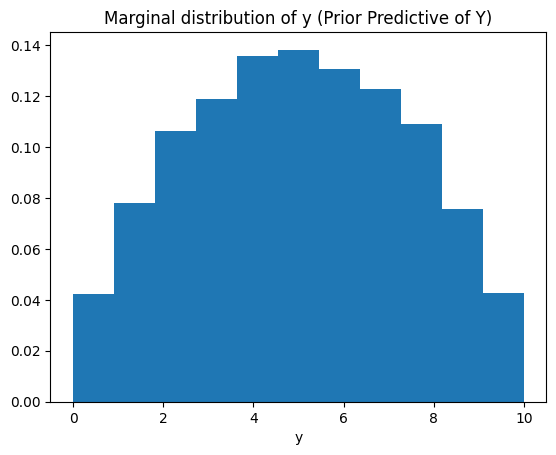

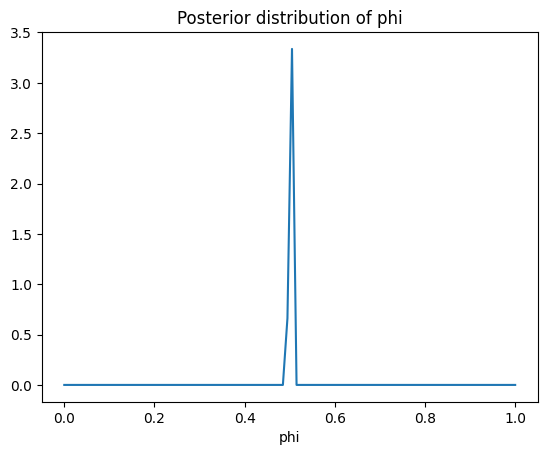

In [9]:
m = 10000 # sample size
a = 2; b = 2

phi = stats.beta.rvs(a, b, size=m)
#Now for each sampled value of phi, run y|phi ~ Binomial(10,phi)
y = np.array([stats.binom.rvs(10, p) for p in phi])

#Now plot the histogram of y
plt.hist(y, bins=11, density=True)
plt.title("Marginal distribution of y (Prior Predictive of Y)")
plt.xlabel("y")
plt.show()

#Posterior
a = 2 + np.sum(y)
b = 2 + 10*m - np.sum(y)
#Now plot the posterior
x = np.linspace(0, 1, 100)
y = stats.beta.pdf(x, a, b)
plt.plot(x, y)
plt.title("Posterior distribution of phi")
plt.xlabel("phi")
plt.show()



### 3. Markov Chains Continuous (Random walk exploration)

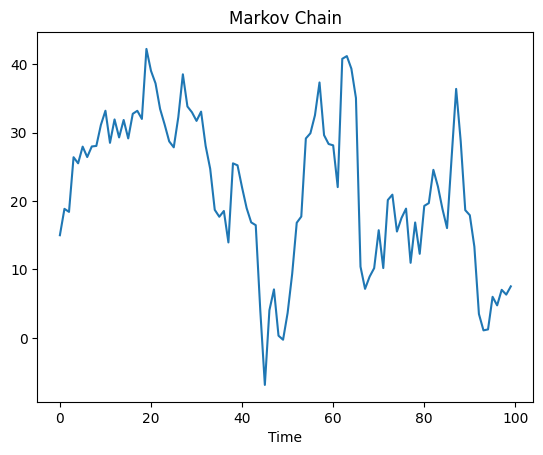

In [10]:
m = 100 #Number of time steps

#Set up a markov chain where P(x_t+1;x_t) = Normal(mean, var)
var = 5
x = np.zeros(m)
x[0] = 15
for t in range(1,m):
    x[t] = stats.t.rvs(10,x[t-1], var)
#Is there a way to vectorise the above?
#Plot the markov chain
plt.plot(x)
plt.title("Markov Chain")
plt.xlabel("Time")
plt.show()

In [11]:
#Make a symmetric numpy 5x5 matrix where diagonals are 0 but X[1,0] = X[2,1] = X[3,2] = X[4,3] = 0.5
X = np.zeros((5,5))
X[0,1] = X[1,0] = 0.5
X[1,2] = X[2,1] = 0.5
X[2,3] = X[3,2] = 0.5
X[3,4] = X[4,3] = 0.5
X[-1,0] = X[0,-1] = 0.5

#Make a A^N matrix
N = 100
A = np.linalg.matrix_power(X, N)
A

array([[0.2, 0.2, 0.2, 0.2, 0.2],
       [0.2, 0.2, 0.2, 0.2, 0.2],
       [0.2, 0.2, 0.2, 0.2, 0.2],
       [0.2, 0.2, 0.2, 0.2, 0.2],
       [0.2, 0.2, 0.2, 0.2, 0.2]])

In [12]:
np.linalg.eig(X)

EigResult(eigenvalues=array([-0.80901699,  0.30901699,  1.        , -0.80901699,  0.30901699]), eigenvectors=array([[ 0.63245553, -0.63245553, -0.4472136 ,  0.22360383, -0.10541895],
       [-0.51166727, -0.19543951, -0.4472136 ,  0.16683981,  0.56051014],
       [ 0.19543951,  0.51166727, -0.4472136 , -0.49355631,  0.45183326],
       [ 0.19543951,  0.51166727, -0.4472136 ,  0.63175107, -0.28126182],
       [-0.51166727, -0.19543951, -0.4472136 , -0.5286384 , -0.62566263]]))

## 4. MCMC
### 4.1 Metropolis Hastings Algo procedure:
The Metropolis-Hastings algorithm is a Markov Chain Monte Carlo (MCMC) method used to generate samples from a target distribution $p(\theta|y)$ when direct sampling is difficult. The procedure is as follows:

1. **Initialize** the algorithm with an arbitrary starting point $\theta^{(0)}$.

2. For each iteration $i = 1$ to $N$, where $N$ is the number of desired samples:

    a. **Generate** a candidate state $\theta^*$ from a proposal distribution $q(\theta^* | \theta^{(i-1)})$. If using a normal distribution as the proposal, this step involves sampling $\theta^* \sim \mathcal{N}(\theta^{(i-1)}, \sigma^2)$, where $\sigma^2$ is the variance of the proposal distribution.

    b. **Calculate** the acceptance ratio $A(\theta^*, \theta^{(i-1)})$ as follows:
    $$A(\theta^*, \theta^{(i-1)}) = \min\left(1, \frac{p(\theta^*|y)q(\theta^{(i-1)}|\theta^*)}{p(\theta^{(i-1)}|y)q(\theta^*|\theta^{(i-1)})}\right)$$
    Since the proposal distribution is symmetric (normal in this case), $q(\theta^*|\theta^{(i-1)}) = q(\theta^{(i-1)}|\theta^*)$, and the acceptance ratio simplifies to:
    $$A(\theta^*, \theta^{(i-1)}) = \min\left(1, \frac{p(\theta^*|y)}{p(\theta^{(i-1)}|y)}\right)$$
    If working with log probabilities, especially for complex target distributions, the log acceptance ratio is:
    $$\log A(\theta^*, \theta^{(i-1)}) = \min\left(0, \log p(\theta^*|y) - \log p(\theta^{(i-1)}|y)\right)$$

    c. **Decide** whether to accept or reject the candidate state $\theta^*$ based on $A(\theta^*, \theta^{(i-1)})$. This is typically done by generating a uniform random number $u \sim \text{Uniform}(0, 1)$ and accepting $\theta^*$ if $u < A(\theta^*, \theta^{(i-1)})$.

    d. **Set** $\theta^{(i)} = \theta^*$ if the candidate is accepted; otherwise, $\theta^{(i)} = \theta^{(i-1)}$.

3. **Repeat** steps 2a to 2d until $N$ samples are generated.

4. **Discard** some initial samples as burn-in, if necessary, and use the remaining samples to approximate the target distribution $p(\theta|y)$.


### 4.1.1 Sample case, Metropolis Hastings use
The situation is as follows: the likelihood of the data $y_i | \mu \sim \mathcal{N}(\mu, 1)$, where we set a prior on $\mu \sim t(0, 1, 1)$. This occurs with a known posterior form $f(\mu | y)$ is proportional to $\frac{\exp\left[n(\bar{y}\mu - \frac{\mu^2}{2})\right]}{1 + \mu^2}$.
We use a Normal Candidate distribution: $q = \mathcal{N}(\mu, s_{0}^2)$, where the value of $s_{0}^2$ relates to the acceptance ratio



In [13]:
#Note we are using log(f) version for the densities
def log_g(mu, n , ybar):
    return n*(ybar*mu - mu**2/2) - np.log(1+mu**2)

def mh_MCMC(n, ybar, n_iter, mu_init, cand_sd): #Assuming the proposal distribution is normal N(mu, cand_sd)
    mu_curr = mu_init
    log_alpha_curr = log_g(mu_curr, n, ybar)
    chain = np.zeros(n_iter)
    accept = 0
    for i in range(n_iter):
        #Sample a candidate using the proposal distribution (normal)
        mu_cand = stats.norm.rvs(mu_curr, cand_sd)
        #Get the acceptance probability. 
        log_alpha_cand = log_g(mu_cand, n, ybar)
        log_alpha = log_alpha_cand - log_alpha_curr
        alpha = np.exp(log_alpha)
        #Use the acceptance
        if np.random.rand() < alpha:
            accept += 1
            mu_curr = mu_cand
            log_alpha_curr = log_alpha_cand

        chain[i] = mu_curr
    return chain, accept/n_iter

In [14]:
#Now say y = c(1.2, 1.4, -0.5, 0.3, 0.9, 2.3, 1.0, 0.1, 1.3, 1.9)
y = np.array([1.2, 1.4, -0.5, 0.3, 0.9, 2.3, 1.0, 0.1, 1.3, 1.9])
ybar = np.mean(y)

chain_mcmc, acceptance_rate = mh_MCMC(len(y), ybar, 1000, 30, 1) #cand_sd will affect the acceptance and we decide it. --> Higher var = Lower Acceptance

Ideally, the MCMC should approach 0.99


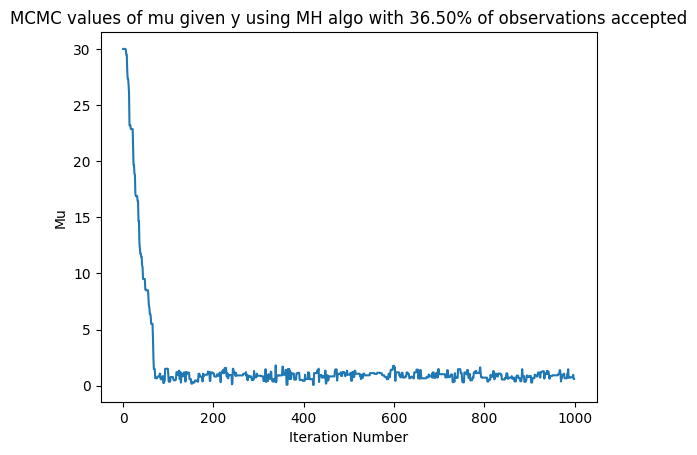

In [15]:
print(f"Ideally, the MCMC should approach {ybar:.2f}")
plt.plot(chain_mcmc)
plt.xlabel("Iteration Number")
plt.ylabel("Mu")
plt.title(f"MCMC values of mu given y using MH algo with {acceptance_rate*100:.2f}% of observations accepted")
plt.show()

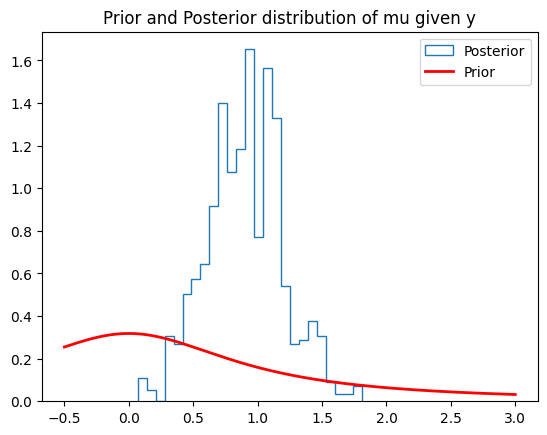

In [16]:
#Do the same as above but without the bars but just a line
plt.hist(chain_mcmc[200:], bins=25, density=True, histtype='step',label='Posterior')
#On the same plot, plot the prior of mu ~ t(0,1,1)
x = np.linspace(-0.5, 3, 1000)
y = stats.t.pdf(x, 1, 0, 1)
plt.plot(x, y, 'r-', lw=2, label='Prior')
plt.gca().set_facecolor('w')
plt.title("Prior and Posterior distribution of mu given y")
plt.legend()
plt.show()

### 4.2: Gibb's Sampling
In the case of a simple metropolis hastings algorithm, what if we had to sample multiple parameters? We can always use a joint distribution for this but it will be highly impractical and require lots of calculations after a while. Gibb's sampling tries to mitigate this by sampling for each parameter at a time and cycling over all parameters in 1 iteration (treating others as constants)

Given a parameter vector $\Theta$ of dimensionality $R^n$, i.e., $\Theta = [\theta_1, \ldots, \theta_n]$, the goal of Gibbs sampling is to generate samples from the joint distribution $p(\Theta | Y)$, where $Y$ is the observed data vector.

The key idea in Gibbs sampling is to iteratively sample from the full conditional distributions of each parameter, holding all other parameters fixed. The full conditional distribution for a parameter $\theta_i$ is defined as:

$$p(\theta_i | \Theta_{-i}, Y)$$

where $\Theta_{-i}$ represents all elements of $\Theta$ excluding $\theta_i$. When other params are fixed, the Metropolis-Hastings algorithm can be applied. The key strength of using the full conditional is that the acceptance ratio (as seen in MH) is always 1 so all candidate params must be accepted.

## Gibbs Sampling Procedure

The Gibbs sampling algorithm can be outlined in the following steps:

1. **Initialize** all parameters $\theta_i$ in $\Theta$ to some starting values.

2. **Iterative Sampling**:
    - For each iteration $t$ of the algorithm, sequentially update each parameter $\theta_i$ in $\Theta$ by sampling from its full conditional distribution $p(\theta_i | \Theta_{-i}^{(t-1)}, Y)$. Specifically, for each parameter $\theta_i$:
        - Sample a new value $\theta_i^{(t)}$ from $p(\theta_i | \Theta_{-i}^{(t-1)}, Y)$.
        - Update $\theta_i$ in $\Theta$ with this new sample $\theta_i^{(t)}$.

3. **Repeat** the iterative sampling step for a large number of iterations to allow the Markov chain to converge to the stationary distribution.

4. **Convergence**:
    - After a sufficient number of iterations, discard some initial samples as burn-in. The remaining samples can be used as approximate draws from the target distribution $p(\Theta | Y)$.


This process generates a sequence of samples for each parameter $\theta_i$, which, after convergence, approximates the joint distribution $p(\Theta | Y)$. The Gibbs sampling method is especially powerful when the conditional distributions are known and easy to sample from, making it a popular choice in Bayesian inference problems.


### 4.2.1 Gibb's Sampling example
Now we take some normally distributed data with independent priors for the mean and standard deviation:

$$y_i \sim \mathcal{N}(\mu,\sigma^2), \quad \mu \sim \mathcal{N}(\mu_{0},\sigma_{0}^2), \quad \sigma^2 \sim \text{Inv-}\Gamma(\nu_{0}, \beta_{0})$$

The priors are chosen because they form conjugate pairs: the normal distribution is conjugate to itself for the mean parameter (when STDev is known), and the inverse gamma distribution is conjugate for the variance parameter (when mean is known) in the Gaussian likelihood.
The joint posterior distribution of $\mu$ and $\sigma^2$ given the data $y$ can be expressed as:

$$ p(\mu, \sigma^2 | y) \propto p(y | \mu,\sigma^2) p(\mu) p(\sigma^2)$$ 
assuming independent priors.

Expanding the terms using the normal and inverse gamma distributions, and simplifying, we get the full conditionals:

1. The full conditional for $\mu$ given $\sigma^2$ and $y$:

$$ p(\mu | \sigma^2, y) \propto \exp\left( -\frac{1}{2\sigma^2} \sum_{i=1}^{n}(y_i - \mu)^2 \right) \exp\left( -\frac{1}{2\sigma_{0}^2} (\mu - \mu_{0})^2 \right) \propto \mathcal{N}\left( \mu \middle| \frac{n\bar{y}/\sigma^2 + \mu_0/\sigma_0^2}{n/\sigma^2 + 1/\sigma_0^2}, \frac{1}{n/\sigma^2 + 1/\sigma_0^2} \right)$$

which simplifies to a normal distribution $\mathcal{N}(\mu_{n}, \sigma_{n}^2)$ with updated parameters $\mu_{n}$ and $\sigma_{n}^2$.

2. The full conditional for $\sigma^2$ given $\mu$ and $y$:

$$ p(\sigma^2 | \mu, y) \propto (\sigma^2)^{-(\nu_{0} + \frac{n}{2} + 1)} \exp\left( -\frac{1}{\sigma^2} \left( \beta_{0} + \frac{1}{2} \sum_{i=1}^{n}(y_i - \mu)^2 \right) \right) \propto \text{Inv-}\Gamma \left( \sigma^2 \middle| \nu_0 + \frac{n}{2}, \beta_0 + \frac{\sum_{i=1}^{n}(y_i - \mu)^2}{2} \right)
  $$

which simplifies to an inverse gamma distribution $\text{Inv-}\Gamma(\nu_{n}, \beta_{n})$ with updated parameters $\nu_{n}$ and $\beta_{n}$.

By iteratively sampling from these full conditionals, we can perform Gibbs sampling to approximate the joint posterior distribution of $\mu$ and $\sigma^2$.

In [33]:
#First, build the sampling functions for mu and sigma^2. Priors and current values are needed
#Assumes priors: mu ~ N(mu_0, sigma2_0), sigma2 ~ Inv-G(nu_0, beta_0)
def sample_mu(n, ybar, sigma2, sigma2_prior, mu_prior):
    #Calculate the mean and std parameters to sample from (for the new mu)
    sigma2_dist = 1/(n/sigma2 + 1/sigma2_prior)
    mu_dist = (n*ybar/sigma2 + mu_prior/sigma2_prior)/(n/sigma2 + 1/sigma2_prior)
    return stats.norm.rvs(mu_dist, np.sqrt(sigma2_dist)) #New mu, noting stdev is put as a parameter

def sample_sigma2(n, y, mu, nu_prior, beta_prior):
    nu_dist = nu_prior + n/2
    beta_dist = beta_prior + np.sum((y-mu)**2)/2
    
    return stats.invgamma.rvs(nu_dist, 1/beta_dist) #Inverse gamma, noting 1/beta_dist is the scale

def gibbs_sampler(y, n_iter, initial_vals, priors):
    #Assumes a dictionary for initial_vals and priors. Initialise the values
    n = len(y); ybar = np.mean(y)
    mu_curr = initial_vals['mu']
    sigma2_curr = initial_vals['sigma2']

    res = np.zeros((n_iter+1, 2))
    res[0,:] = mu_curr, sigma2_curr
    #Run the main gibbs sampler
    for i in range(1,n_iter+1):
        #Update mu first: (For priors: mu ~ N(mu_0, sigma2_0), sigma2 ~ IG(nu_0, beta_0))
        mu_curr = sample_mu(n, ybar, sigma2_curr, priors['sigma2_0'], priors['mu_0'])
        #Use the new mu to sample the new sigma2
        sigma2_curr = sample_sigma2(n, y, mu_curr, priors['nu_0'],priors['beta_0'])
        res[i,:] = mu_curr, sigma2_curr
    
    return res

y = np.array([1.2, 1.4, -0.5, 0.3, 0.9, 2.3, 1.0, 0.1, 1.3, 1.9])
prior = {'mu_0':0.0, 'sigma2_0': 1.0, 'nu_0': 1.0, 'beta_0': 1.0}
initial_guess = {'mu': 0.0, 'sigma2': 1.0}
res = gibbs_sampler(y, 10000, initial_guess, prior)

#Take out the burn-in:
res = res[100:,:]

#Compare the best estimates with the observed values
print(f"The observed mean of y is {np.mean(y): .2f} and the observed variance is {np.var(y): .2f}")
print(f'The estimated mean of y is {np.mean(res[:,0]): .2f} and the estimated variance is {np.mean(res[:,1]): .2f}')


The observed mean of y is  0.99 and the observed variance is  0.63
The estimated mean of y is  0.95 and the estimated variance is  0.43


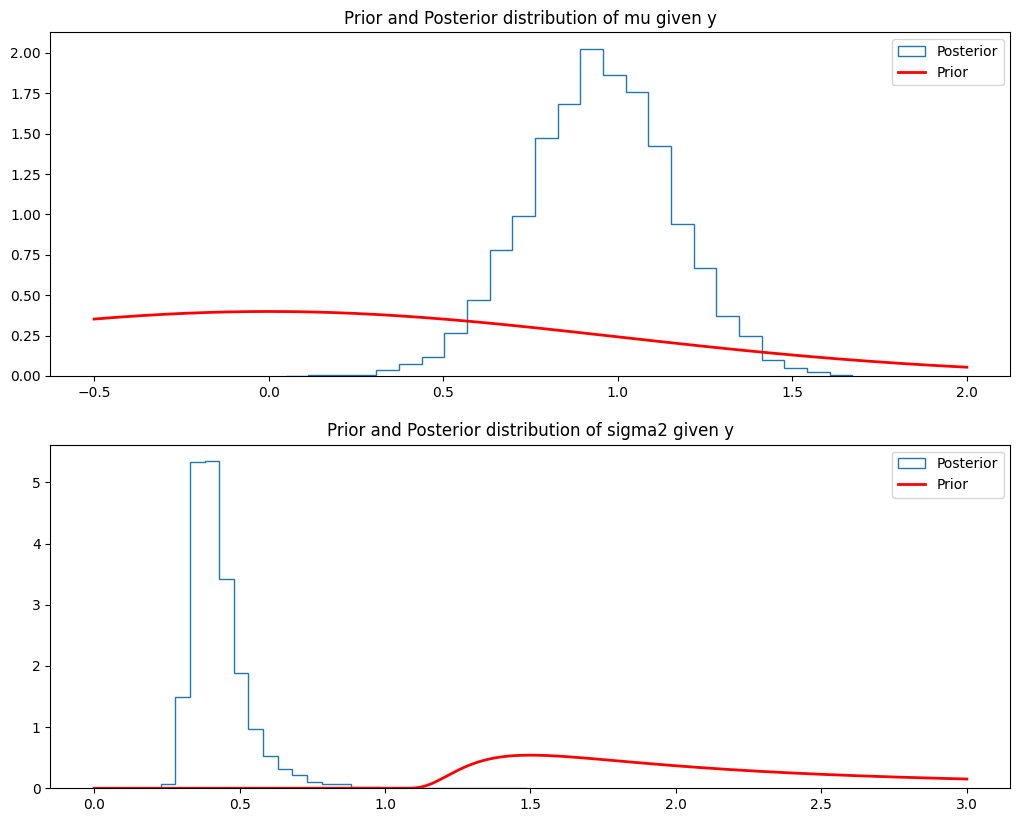

In [18]:
#Now plot the results with their respective priors
fig, axes = plt.subplots(2, 1, figsize=(12, 12))
fig.subplots_adjust(left=0.1, right=0.9, bottom=0.25)

axes[0].hist(res[:,0], bins=25, density=True, histtype='step',label='Posterior')
x = np.linspace(-0.5, 2, 1000)
y = stats.norm.pdf(x, 0, 1)
axes[0].plot(x, y, 'r-', lw=2, label='Prior')
axes[0].set_title("Prior and Posterior distribution of mu given y")
axes[0].legend()

axes[1].hist(res[:,1], bins=25, density=True, histtype='step',label='Posterior')
x = np.linspace(0, 3, 1000)
y = stats.invgamma.pdf(x, 1, 1)
axes[1].plot(x, y, 'r-', lw=2, label='Prior')
axes[1].set_title("Prior and Posterior distribution of sigma2 given y")
axes[1].legend()
plt.show()


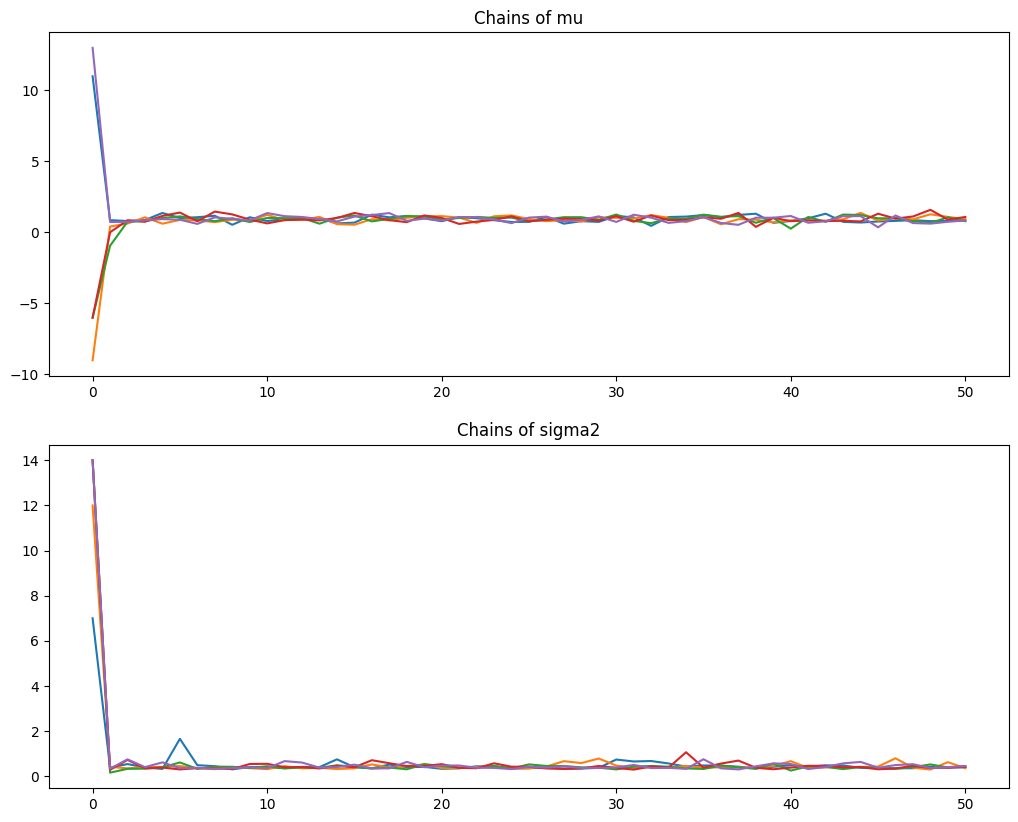

In [39]:
#Check for divergence using multiple chains with different initial values
n_chains = 5
n_iter = 50
res = np.zeros((n_chains, n_iter+1, 2))
for i in range(n_chains):
    initial_guess = {'mu': np.random.randint(low = -25, high = 25), 'sigma2': np.random.randint(low = 5, high = 15)}    
    res[i,:,:] = gibbs_sampler(y, n_iter, initial_guess, prior)

#Burn in was not removed to show the evolution of the chain and how it converges to the same value.
#Plot the chains
fig, axes = plt.subplots(2, 1, figsize=(12, 12))
fig.subplots_adjust(left=0.1, right=0.9, bottom=0.25)

for i in range(n_chains):
    axes[0].plot(res[i,:,0])
    axes[1].plot(res[i,:,1])

axes[0].set_title("Chains of mu")
axes[1].set_title("Chains of sigma2")
plt.show()


This was the case when the updating params were known and the parameters followed a standard distribution. If the full distribution does not follow a standard distribution, then a metropolis-hastings can be used within each iteration.

### 4.3: PyMC
It's impractical to hardcode everything for us when we know that there is already someone out there (much smarter) that has developed this

In [20]:
import pymc as pm
import arviz as az

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


#### About the model: (Refer to their documentation for more)
The model is based around the Model() object. It uses a context manager when defining the model. Now a sample case study: first consider a simple p=2 linear regression case where

$$Y = \alpha + \beta_{1} X_{1} + \beta_{2}X_{2} + \epsilon \quad \text{where } \epsilon = \sigma\mathcal{N}(0,1)$$




In [21]:
#Generate the data first with known true parameters
alpha,sigma = 1,1
beta = [1,2.5]

n = 100

#Sample Data Set:
X1 = np.random.randn(n)
X2 = np.random.randn(n) * 0.2

#Simulate outcome variable
Y = alpha + beta[0]*X1 + beta[1]*X2 + np.random.randn(n)*sigma

#Given above, our bayesian model should favour the true parameters.

In [22]:
with pm.Model() as model:
    alpha = pm.Normal("Alpha", mu=0, sigma=10)
    beta = pm.Normal("Beta", mu=0, sigma=10, shape=2) #Shape is the number of RVs
    sigma = pm.HalfNormal("Sigma", sigma=1) #Half normal is a normal distribution with a lower bound of 0

    mu = alpha + pm.math.dot(beta, [X1, X2])

    #Only the error term is a random variable this makes the Y_obs normally distributed.
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)
    #This one is an observed stochastic -> RVs that are observed and should not be changed by the sampler

In [23]:
print(model.basic_RVs) #This will show the RVs in the model

#Now we sample from the model
with model:
    trace = pm.sample(10000, tune=1000)

[Alpha, Beta, Sigma, Y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Alpha, Beta, Sigma]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 3 seconds.


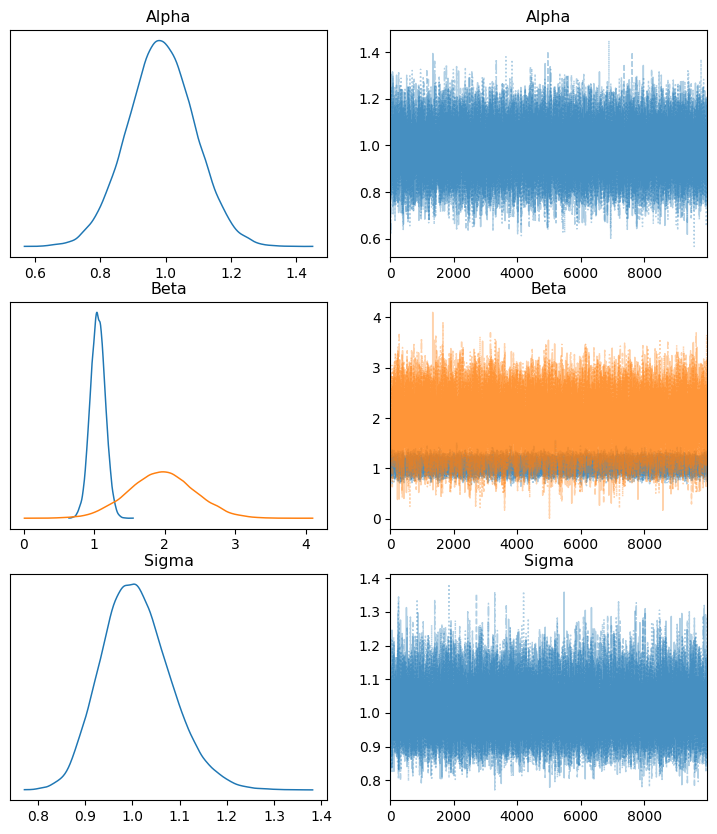

In [24]:
az.plot_trace(trace, combined=True);
#Make the plot bigger
plt.gcf().set_size_inches(9, 10)


In [25]:
az.summary(trace, round_to=2)
#True values are 1, 1, 2.5, 1 1111

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Alpha,0.99,0.10,0.79,1.17,0.0,0.0,60150.58,33401.69,1.0
Beta[0],1.05,0.10,0.85,1.25,0.0,0.0,59263.67,33183.14,1.0
Beta[1],1.95,0.47,1.09,2.84,0.0,0.0,61242.10,32674.75,1.0
Sigma,1.01,0.07,0.87,1.15,0.0,0.0,52269.94,32294.94,1.0
